# 흑백사진 복원

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 50

In [7]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# 저장 된 np array 불러오기
#텍스트 데이터를 제외한 나머지 경우는 np.load를 이용하여 읽을 수 있고 텍스트 데이터는 np.loadtxt를 사용한다.


""" ex) $ x = np.load("./save/data.npy")

    # 여러 array가 있는 경우 저장한 이름을 index로 사용

    $ saved_npz = np.load("./save/without_compression_data.npz")

    $ saved_npz = np.load("./save/compression_data.npz")

    $ y = saved_npz ['y']

    $ z = saved_npz ['z'] """

1.데이터 불러오기


In [8]:
pfcn = np.load('/gdrive/My Drive/pfcn_small.npz')

train_images = pfcn['train_images']
test_images = pfcn['test_images']

2.전처리 및 시각화

In [9]:
train_images.shape, test_images.shape

((1700, 100, 75, 3), (300, 100, 75, 3))

3.흑백 이미지 train_gray_images, test_gray_images 만들기

In [ ]:
# from skimage import color 
# rgb to gray scal 
# 모듈의 rgb to gray() 함수는  rgb 이미지를 그레이 스케일 이미지로 변환 

In [10]:

from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images]) #depth차원을 위해 1을 넣어 reshape
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


In [ ]:
# img.transpose(1, 0, 2)는 원래 height, width, layer였던 구조를 width, height, layer로 바꾸겠다는 말

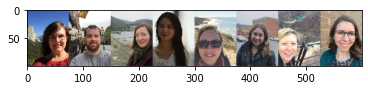

In [11]:
plt.imshow(train_images[:8].transpose((1,0,2,3)).reshape((100, -1, 3)))
plt.show()

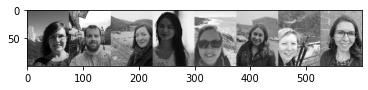

In [12]:
plt.imshow(train_gray_images[:8][...,0].transpose((1,0,2)).reshape((100, -1)), cmap = 'gray')
plt.show()

4.모델링 U-net 흑백 을 컬러로 만들기

In [13]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

In [14]:
def conv2d_block(x, channel):
  x = Conv2D(channel, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(channel, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [15]:
def unet_color():
  inputs = Input((100, 75, 1))   #흑백이미지 인풋

  c1 = conv2d_block(inputs, 16)
  p1 = MaxPool2D(2)(c1)
  p1 = Dropout(0.1)(p1)

  c2 = conv2d_block(p1, 32)
  p2 = MaxPool2D(2)(c2)
  p2 = Dropout(0.1)(p2)

  c3 = conv2d_block(p2, 64)
  p3 = MaxPool2D(2)(c3)
  p3 = Dropout(0.1)(p3)

  c4 = conv2d_block(p3, 128)
  p4 = MaxPool2D(2)(c4)
  p4 = Dropout(0.1)(p4)

  c5 = conv2d_block(p4, 256)

  u6 = Conv2DTranspose(128, 2, 2, padding = 'valid', output_padding=(0,1))(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(0.1)(u6)
  c6 = conv2d_block(u6, 128)

  u7 = Conv2DTranspose(64, 2, 2, padding = 'valid', output_padding=(1,0))(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(0.1)(u7)
  c7 = conv2d_block(u7, 64)

  u8 = Conv2DTranspose(32, 2, 2, padding = 'valid', output_padding=(0,1))(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(0.1)(u8)
  c8 = conv2d_block(u8, 32)

  u9 = Conv2DTranspose(16, 2, 2, padding = 'valid', output_padding=(0,1))(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(0.1)(u9)
  c9 = conv2d_block(u9, 16)

  outputs = Conv2D(3, 1, activation = 'sigmoid')(c9)
  model = Model(inputs, outputs)
  return model
  
model = unet_color()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 75, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 75, 16)  160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 75, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [17]:
model.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])

project = model.fit(train_gray_images, train_images, validation_data=(test_gray_images, test_images), epochs=20, verbose = 1)

Epoch 1/20
54/54 [==============================] - 10s 132ms/step - loss: 0.0070 - accuracy: 0.6497 - val_loss: 0.0068 - val_accuracy: 0.6530
Epoch 2/20
54/54 [==============================] - 6s 119ms/step - loss: 0.0070 - accuracy: 0.6530 - val_loss: 0.0085 - val_accuracy: 0.6260
Epoch 3/20
54/54 [==============================] - 6s 119ms/step - loss: 0.0066 - accuracy: 0.6524 - val_loss: 0.0073 - val_accuracy: 0.6208
Epoch 4/20
54/54 [==============================] - 6s 119ms/step - loss: 0.0064 - accuracy: 0.6593 - val_loss: 0.0073 - val_accuracy: 0.6634
Epoch 5/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0065 - accuracy: 0.6604 - val_loss: 0.0088 - val_accuracy: 0.6147
Epoch 6/20
54/54 [==============================] - 6s 120ms/step - loss: 0.0061 - accuracy: 0.6683 - val_loss: 0.0069 - val_accuracy: 0.6617
Epoch 7/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0062 - accuracy: 0.6724 - val_loss: 0.0085 - val_accuracy: 0.5772
Epoch

In [18]:
res = model.predict(test_gray_images[1:30])
print(test_gray_images[1:30].shape)
print(res.shape)

(29, 100, 75, 1)
(29, 100, 75, 3)


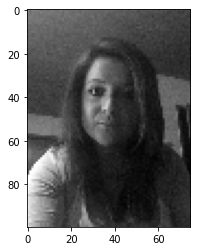

In [19]:
plt.imshow(test_gray_images[29][...,0], cmap = 'gray')
plt.show()

In [ ]:
# 원본과 복원한 사진 비교 

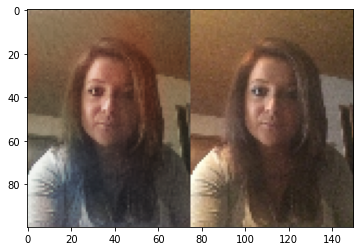

In [20]:
plt.imshow(np.concatenate([res[28],test_images[29]], axis = 1))
plt.show()

In [ ]:
# 연속적 5장 사진과 원본 비교 

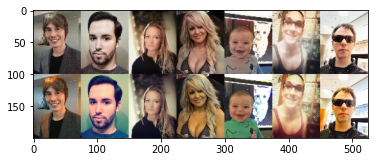

In [21]:
seven = model.predict(test_gray_images[:7])
plt.imshow(np.concatenate([seven, test_images[:7]], axis = 1).transpose((1,0,2,3)).reshape((200,-1,3)))
plt.show()

In [ ]:
# 결과가 그리 뛰어나 보이진 않는다.

In [ ]:
# 좀더 향상 시킬수 있는 방법이 뭐가 있을까?

5. LAB 컬러 모델링



In [ ]:
#rgb컬러를 lab컬러로 변경

In [22]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [ ]:
# lab컬러의 경우 밝기 채널의 경우 0~100, 나머지 채널은 ±128의 범위 . 데이터에 0~1로 노말라이즈를 적용

In [23]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

In [ ]:
# 변환 이미지 확인

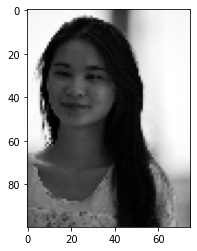

In [34]:
plt.imshow(train_lab_images[3][...,0], cmap = 'gray') #0번채널만 확인한다면 흑백 사진
plt.show()

In [ ]:
# Lab컬러의 첫번째 채널로 나머지 2채널을 예측하는 모델

In [25]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
  x = Conv2D(channel, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(channel, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def unet_lab():
  inputs = Input((100, 75, 1))   #흑백이미지 인풋

  c1 = conv2d_block(inputs, 16)
  p1 = MaxPool2D(2)(c1)
  p1 = Dropout(0.1)(p1)

  c2 = conv2d_block(p1, 32)
  p2 = MaxPool2D(2)(c2)
  p2 = Dropout(0.1)(p2)

  c3 = conv2d_block(p2, 64)
  p3 = MaxPool2D(2)(c3)
  p3 = Dropout(0.1)(p3)

  c4 = conv2d_block(p3, 128)
  p4 = MaxPool2D(2)(c4)
  p4 = Dropout(0.1)(p4)

  c5 = conv2d_block(p4, 256)

  u6 = Conv2DTranspose(128, 2, 2, padding = 'valid', output_padding=(0,1))(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(0.1)(u6)
  c6 = conv2d_block(u6, 128)

  u7 = Conv2DTranspose(64, 2, 2, padding = 'valid', output_padding=(1,0))(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(0.1)(u7)
  c7 = conv2d_block(u7, 64)

  u8 = Conv2DTranspose(32, 2, 2, padding = 'valid', output_padding=(0,1))(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(0.1)(u8)
  c8 = conv2d_block(u8, 32)

  u9 = Conv2DTranspose(16, 2, 2, padding = 'valid', output_padding=(0,1))(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(0.1)(u9)
  c9 = conv2d_block(u9, 16)

  outputs = Conv2D(2, 1, activation = 'sigmoid')(c9)
  model = Model(inputs, outputs)
  return model
  
model2 = unet_lab()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 75, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 100, 75, 16)  160         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 100, 75, 16)  64         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [27]:
model2.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])
improve = model2.fit(train_lab_images[...,0:1], train_lab_images[...,1:], validation_data=(test_lab_images[...,0:1], test_lab_images[...,1:]), epochs=20, verbose = 1)

Epoch 1/20
54/54 [==============================] - 10s 131ms/step - loss: 0.0070 - accuracy: 0.5331 - val_loss: 0.0030 - val_accuracy: 0.5981
Epoch 2/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0031 - accuracy: 0.5682 - val_loss: 0.0045 - val_accuracy: 0.5663
Epoch 3/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0028 - accuracy: 0.5953 - val_loss: 0.0030 - val_accuracy: 0.5981
Epoch 4/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0027 - accuracy: 0.6032 - val_loss: 0.0030 - val_accuracy: 0.5983
Epoch 5/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0027 - accuracy: 0.6011 - val_loss: 0.0029 - val_accuracy: 0.5998
Epoch 6/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0027 - accuracy: 0.6098 - val_loss: 0.0027 - val_accuracy: 0.6260
Epoch 7/20
54/54 [==============================] - 6s 118ms/step - loss: 0.0027 - accuracy: 0.6096 - val_loss: 0.0028 - val_accuracy: 0.6029
Epoch

In [ ]:
# 모델 결과를 res변수에 저장 후 plt 출력

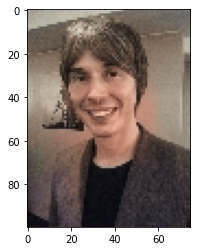

In [39]:
res = model2.predict(test_lab_images[1:35][...,0:1])
def l2rgb(a):
  pred_ab = model2.predict(np.expand_dims(a, 0))  #차원을 추가
  pred_img = np.zeros((100, 75, 3))

  pred_img[:,:,0] = a.reshape((100, 75))
  pred_img[:,:,1:] = pred_ab[0]

  pred_lab = (pred_img * [100,255,255]) - [0,128,128]
  rgb_img = color.lab2rgb(pred_lab)
  return rgb_img
  
plt.imshow(l2rgb(test_lab_images[0][...,0]))
plt.show()

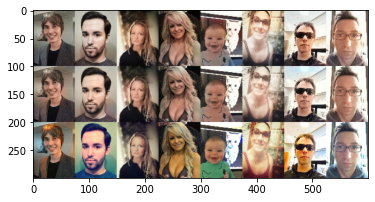

In [40]:
sample = model.predict(test_gray_images[:8])
sample2 = np.array([l2rgb(img) for img in test_lab_images[:8][...,0]])
plt.imshow(np.concatenate([sample,sample2, test_images[:8]], axis = 1).transpose((1,0,2,3)).reshape((300,-1,3)))
plt.show()

In [ ]:
# 별 차이는 없어보이나 좀더 나아보인다?